# About Project
* Predictive maintenance models to predict device failure which can help redusing costs of maintenance.

In [1]:
from utils import *

## Loading  dataset 

In [2]:
df = pd.read_csv('Data/train.csv')
# pandas_profiling.ProfileReport(df)

### Data explanation

In [3]:
df.Date = pd.to_datetime(df.Date)
df['Activedays']=df.Date-df.Date[0]
df['Month']=df['Date'].dt.month
df['Week_day']=df.Date.dt.weekday
df['Week_day'].replace(0,7,inplace=True)

In [4]:
season = []
for dt in df.Date:
    if dt < datetime(2020,3,1):
        season.append('winter')
    elif dt < datetime(2020,6,1):
        season.append('spring')
    elif dt<datetime(2020,9,1):
        season.append('summer')
    else:
        season.append('fall')

df['Season']=season
df.head()

,Date,Device_ID,Sensor1,Sensor2,Sensor3,Sensor4,Sensor5,Sensor6,Sensor7,Sensor8,Sensor9,Fail,Activedays,Month,Week_day,Season
0,2020-01-01,Radar11085,215630672,56,0,52,6,407438,0,0,7,0,0 days,1,2,winter
1,2020-01-01,Radar1166B,61370680,0,3,0,6,403174,0,0,0,0,0 days,1,2,winter
2,2020-01-01,Radar11E6Y,173295968,0,0,0,12,237394,0,0,0,0,0 days,1,2,winter
3,2020-01-01,Radar11JE0,79694024,0,0,0,6,410186,0,0,0,0,0 days,1,2,winter
4,2020-01-01,Radar11R2B,135970480,0,0,0,15,313173,0,0,3,0,0 days,1,2,winter


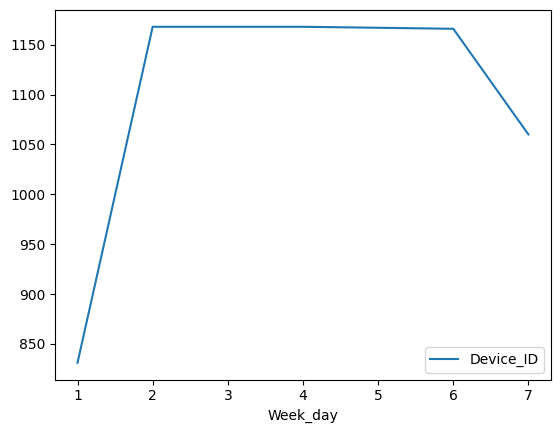

In [5]:
# Count of devices for each month
df.groupby('Week_day').agg({'Device_ID':lambda x: x.nunique()}).plot()
plt.show()

### Data visualization 

[]

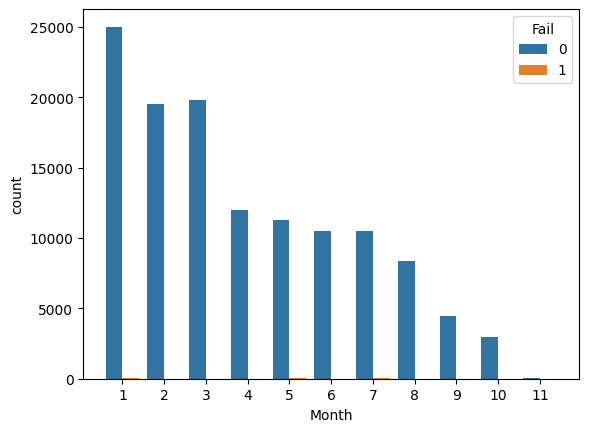

In [6]:
# Failed devices number per month
ax = sns.countplot(x="Month", hue="Fail", data=df)
ax.plot()

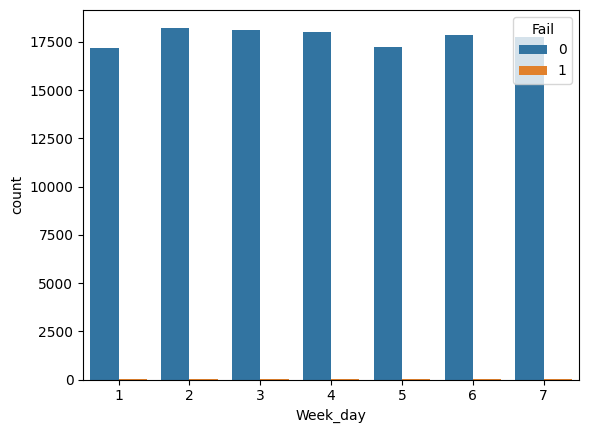

In [7]:
# Failed devices number per week day
ax = sns.countplot(x='Week_day',hue='Fail',data=df)

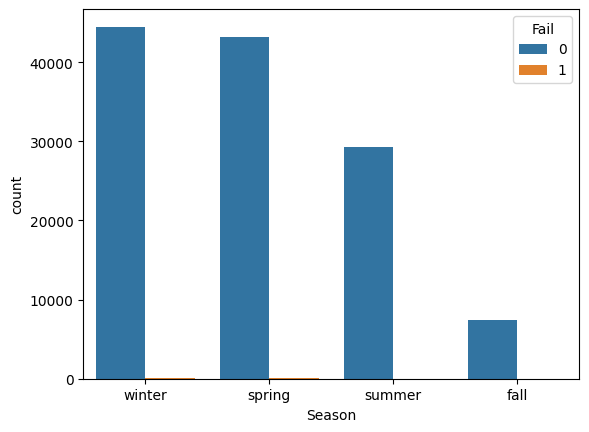

In [8]:
# Failed devices number per Season
ax = sns.countplot(x='Season',hue='Fail',data=df)

### Fixed Devices

In [9]:
df_date = df.groupby('Device_ID').agg({'Date':max})
df_date.Date.to_dict()
df_failure = df.loc[df.Fail==1,['Device_ID','Date']]
df_good = df.loc[df.Fail==0,['Device_ID','Date']]
df['max_date']=df.Device_ID.map(df_date.Date.to_dict())
dff=df[(df.Fail==1)&(df.Date!=df.max_date)]

## Reduce data set with unique device id

In [10]:
df1 = df.groupby('Device_ID').agg({'Date':max})
df1=df1.reset_index()
df=df.reset_index(drop=True) 
df2= pd.merge(df1,df,how='left',on=['Device_ID','Date'])

## Redefine device Id value

<AxesSubplot: xlabel='Device_ID', ylabel='count'>

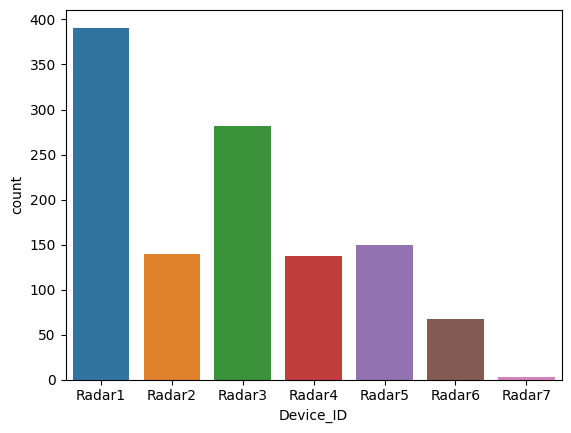

In [11]:
#change device id values to the first six characters

Id = df2.Device_ID.values.tolist()
Id1 = [] 
for i in Id:
    i = i[:6]
    Id1.append(i)
df2.Device_ID=Id1
df2.Device_ID.value_counts()
sns.countplot(x='Device_ID',data=df2)

## Data transformation

In [12]:
#redefine data type for some of the numerical features
cat_ftrs = ['Sensor3','Sensor4', 'Sensor5', 'Sensor7', 'Sensor9'] 
for col in cat_ftrs:
    df2[col]=df2[col].astype('object')

In [13]:
df2.Activedays = df2.Activedays.astype('str')
df2.Activedays=df2.Activedays.apply(str_to_num)
df2.Activedays = df2.Activedays.astype('int')

In [14]:
for col in ['Month','Week_day', 'Season']:
    df2[col]=df2[col].astype('object')

In [15]:
#numerical features standardization
scaler = StandardScaler()
num_ftrs =['Sensor1','Sensor2','Sensor6'] 
df2[num_ftrs]=scaler.fit_transform(df2[num_ftrs])

## Drop unimportant and redundant features 

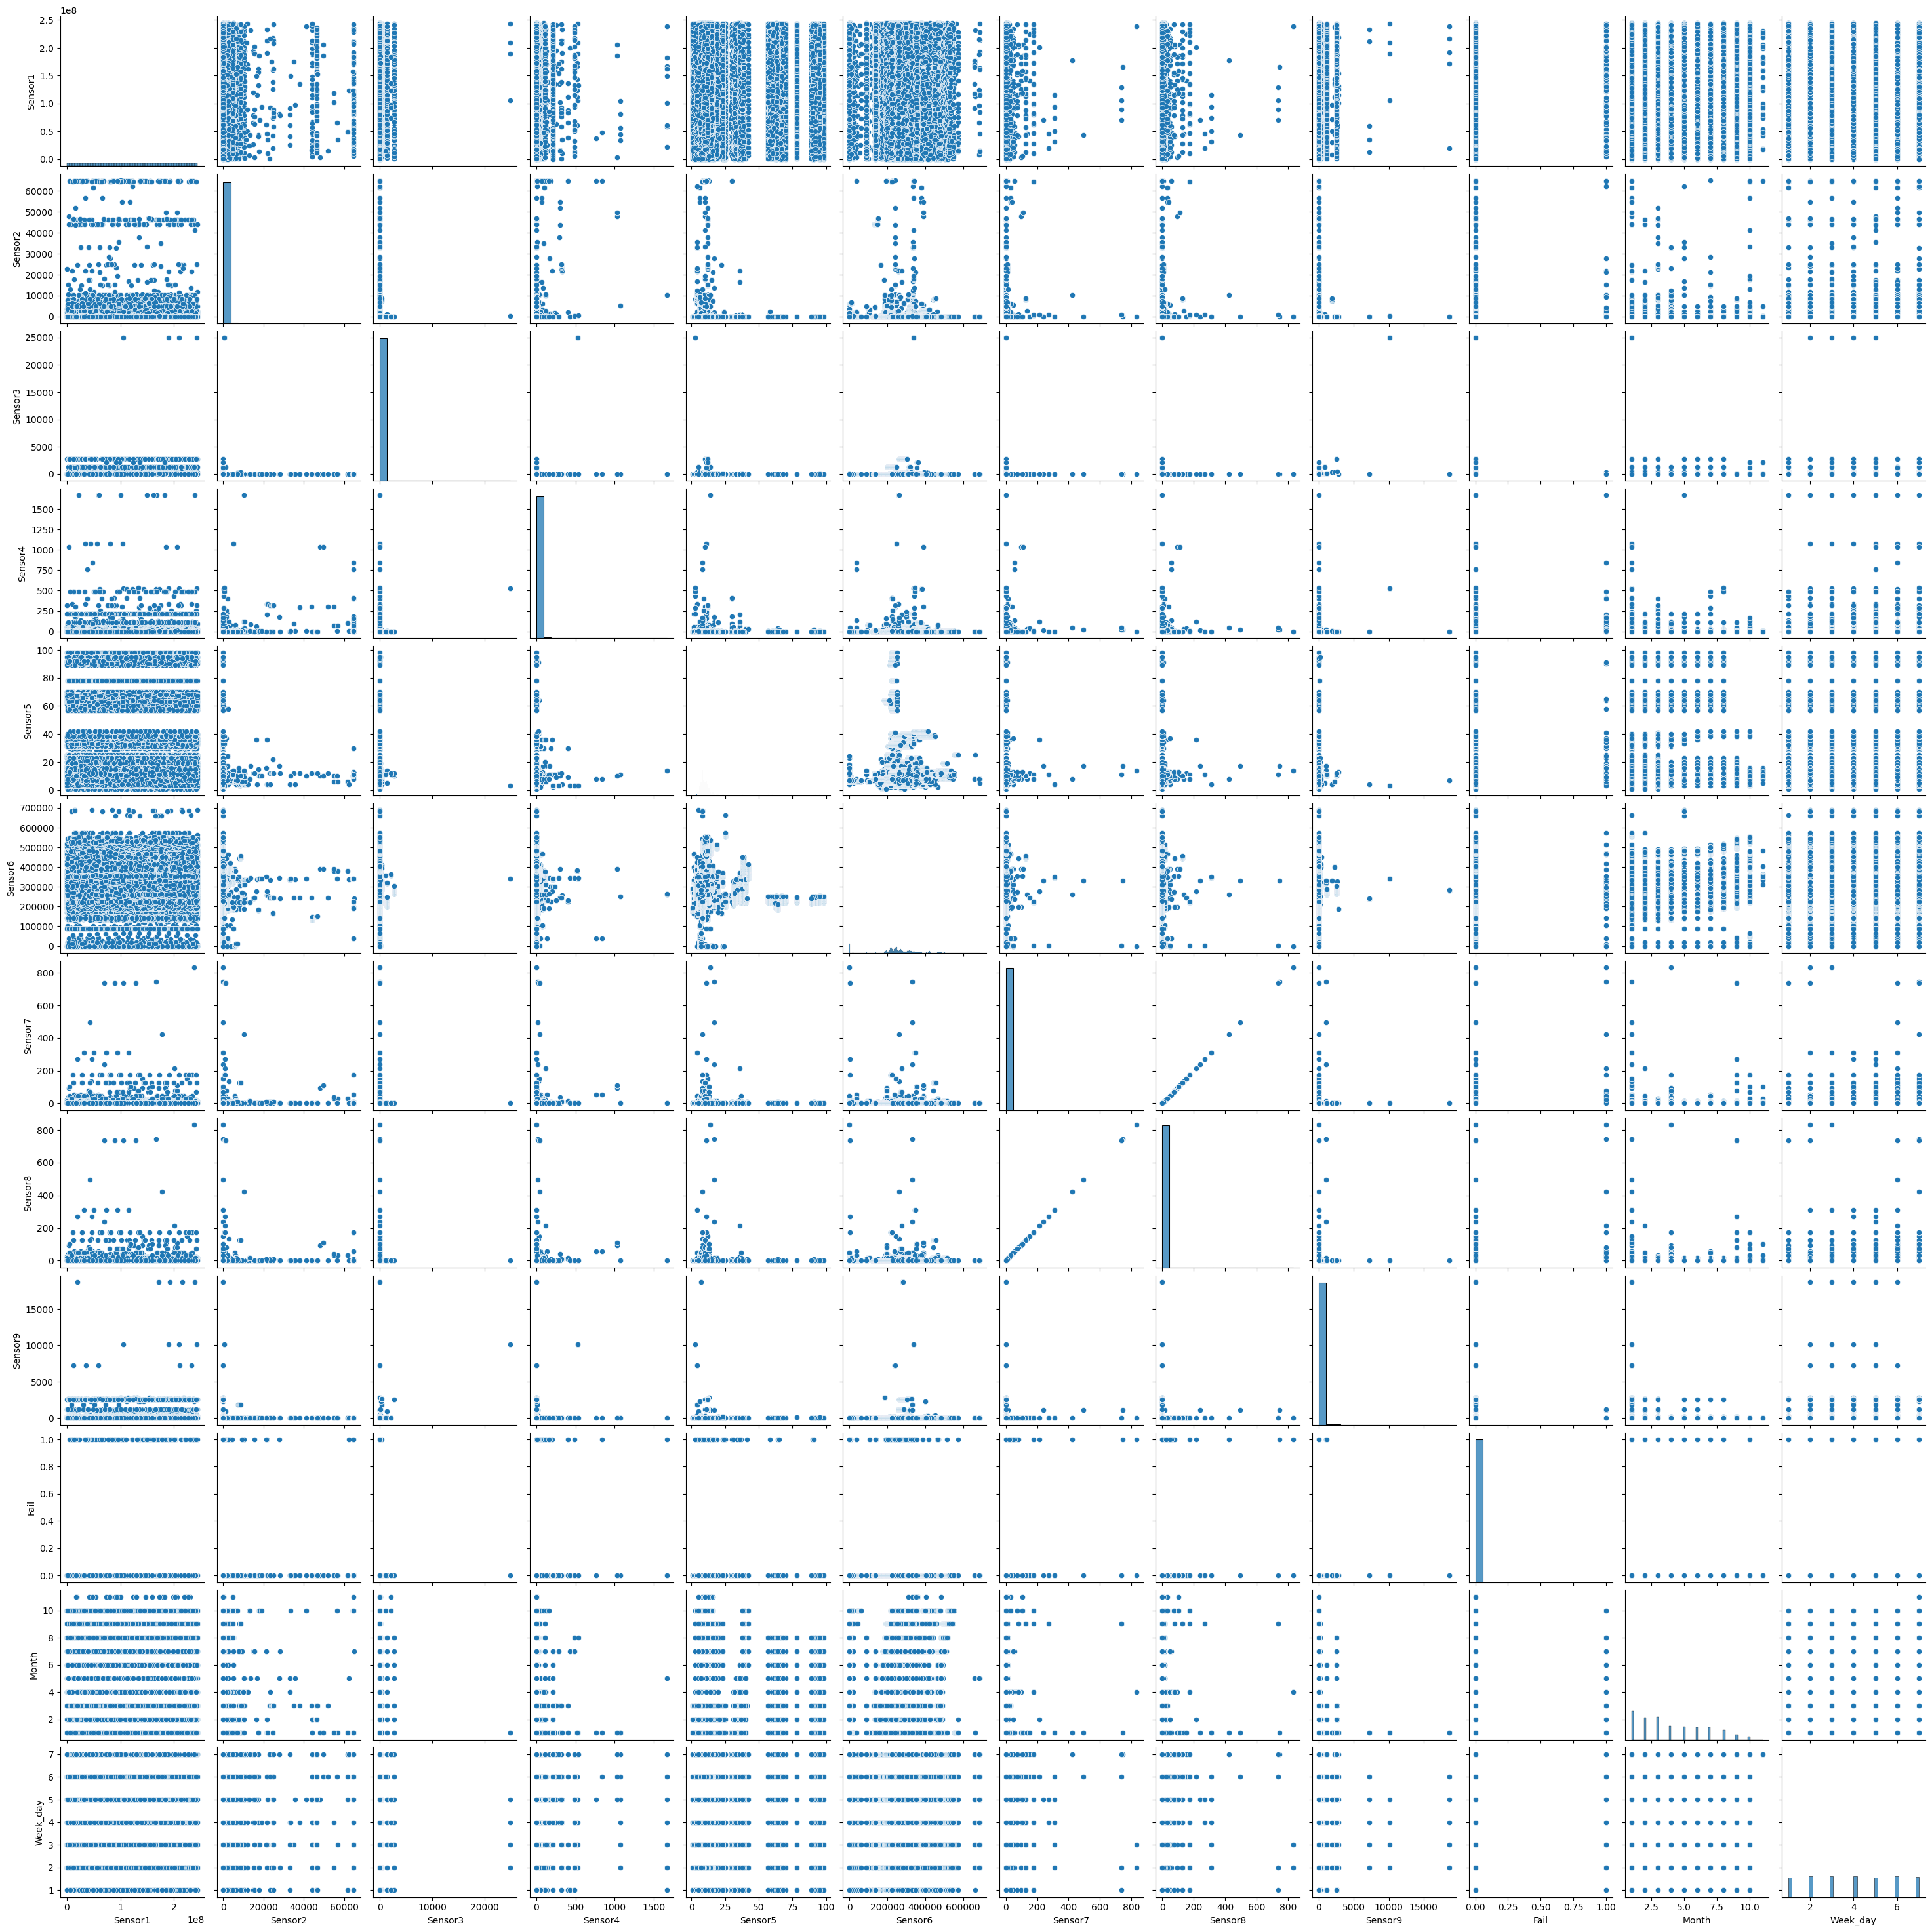

In [16]:
sns.pairplot(df)

In [17]:
# Sensor7 and Sensor8 is highly linear related or equal to each other
df.drop('Sensor8',axis=1,inplace=True)
df = df.reset_index(drop=True)

In [18]:
df2.drop(['Date','max_date'], axis=1, inplace=True)

In [19]:
# One hot encoding
df2 = pd.get_dummies(df2, drop_first=True)

# Feature Selection

## Define dependent and independent values

In [20]:
X = df2.drop('Fail',axis=1)
Y = df2.Fail

## Feature Selection

<AxesSubplot: ylabel='feature'>

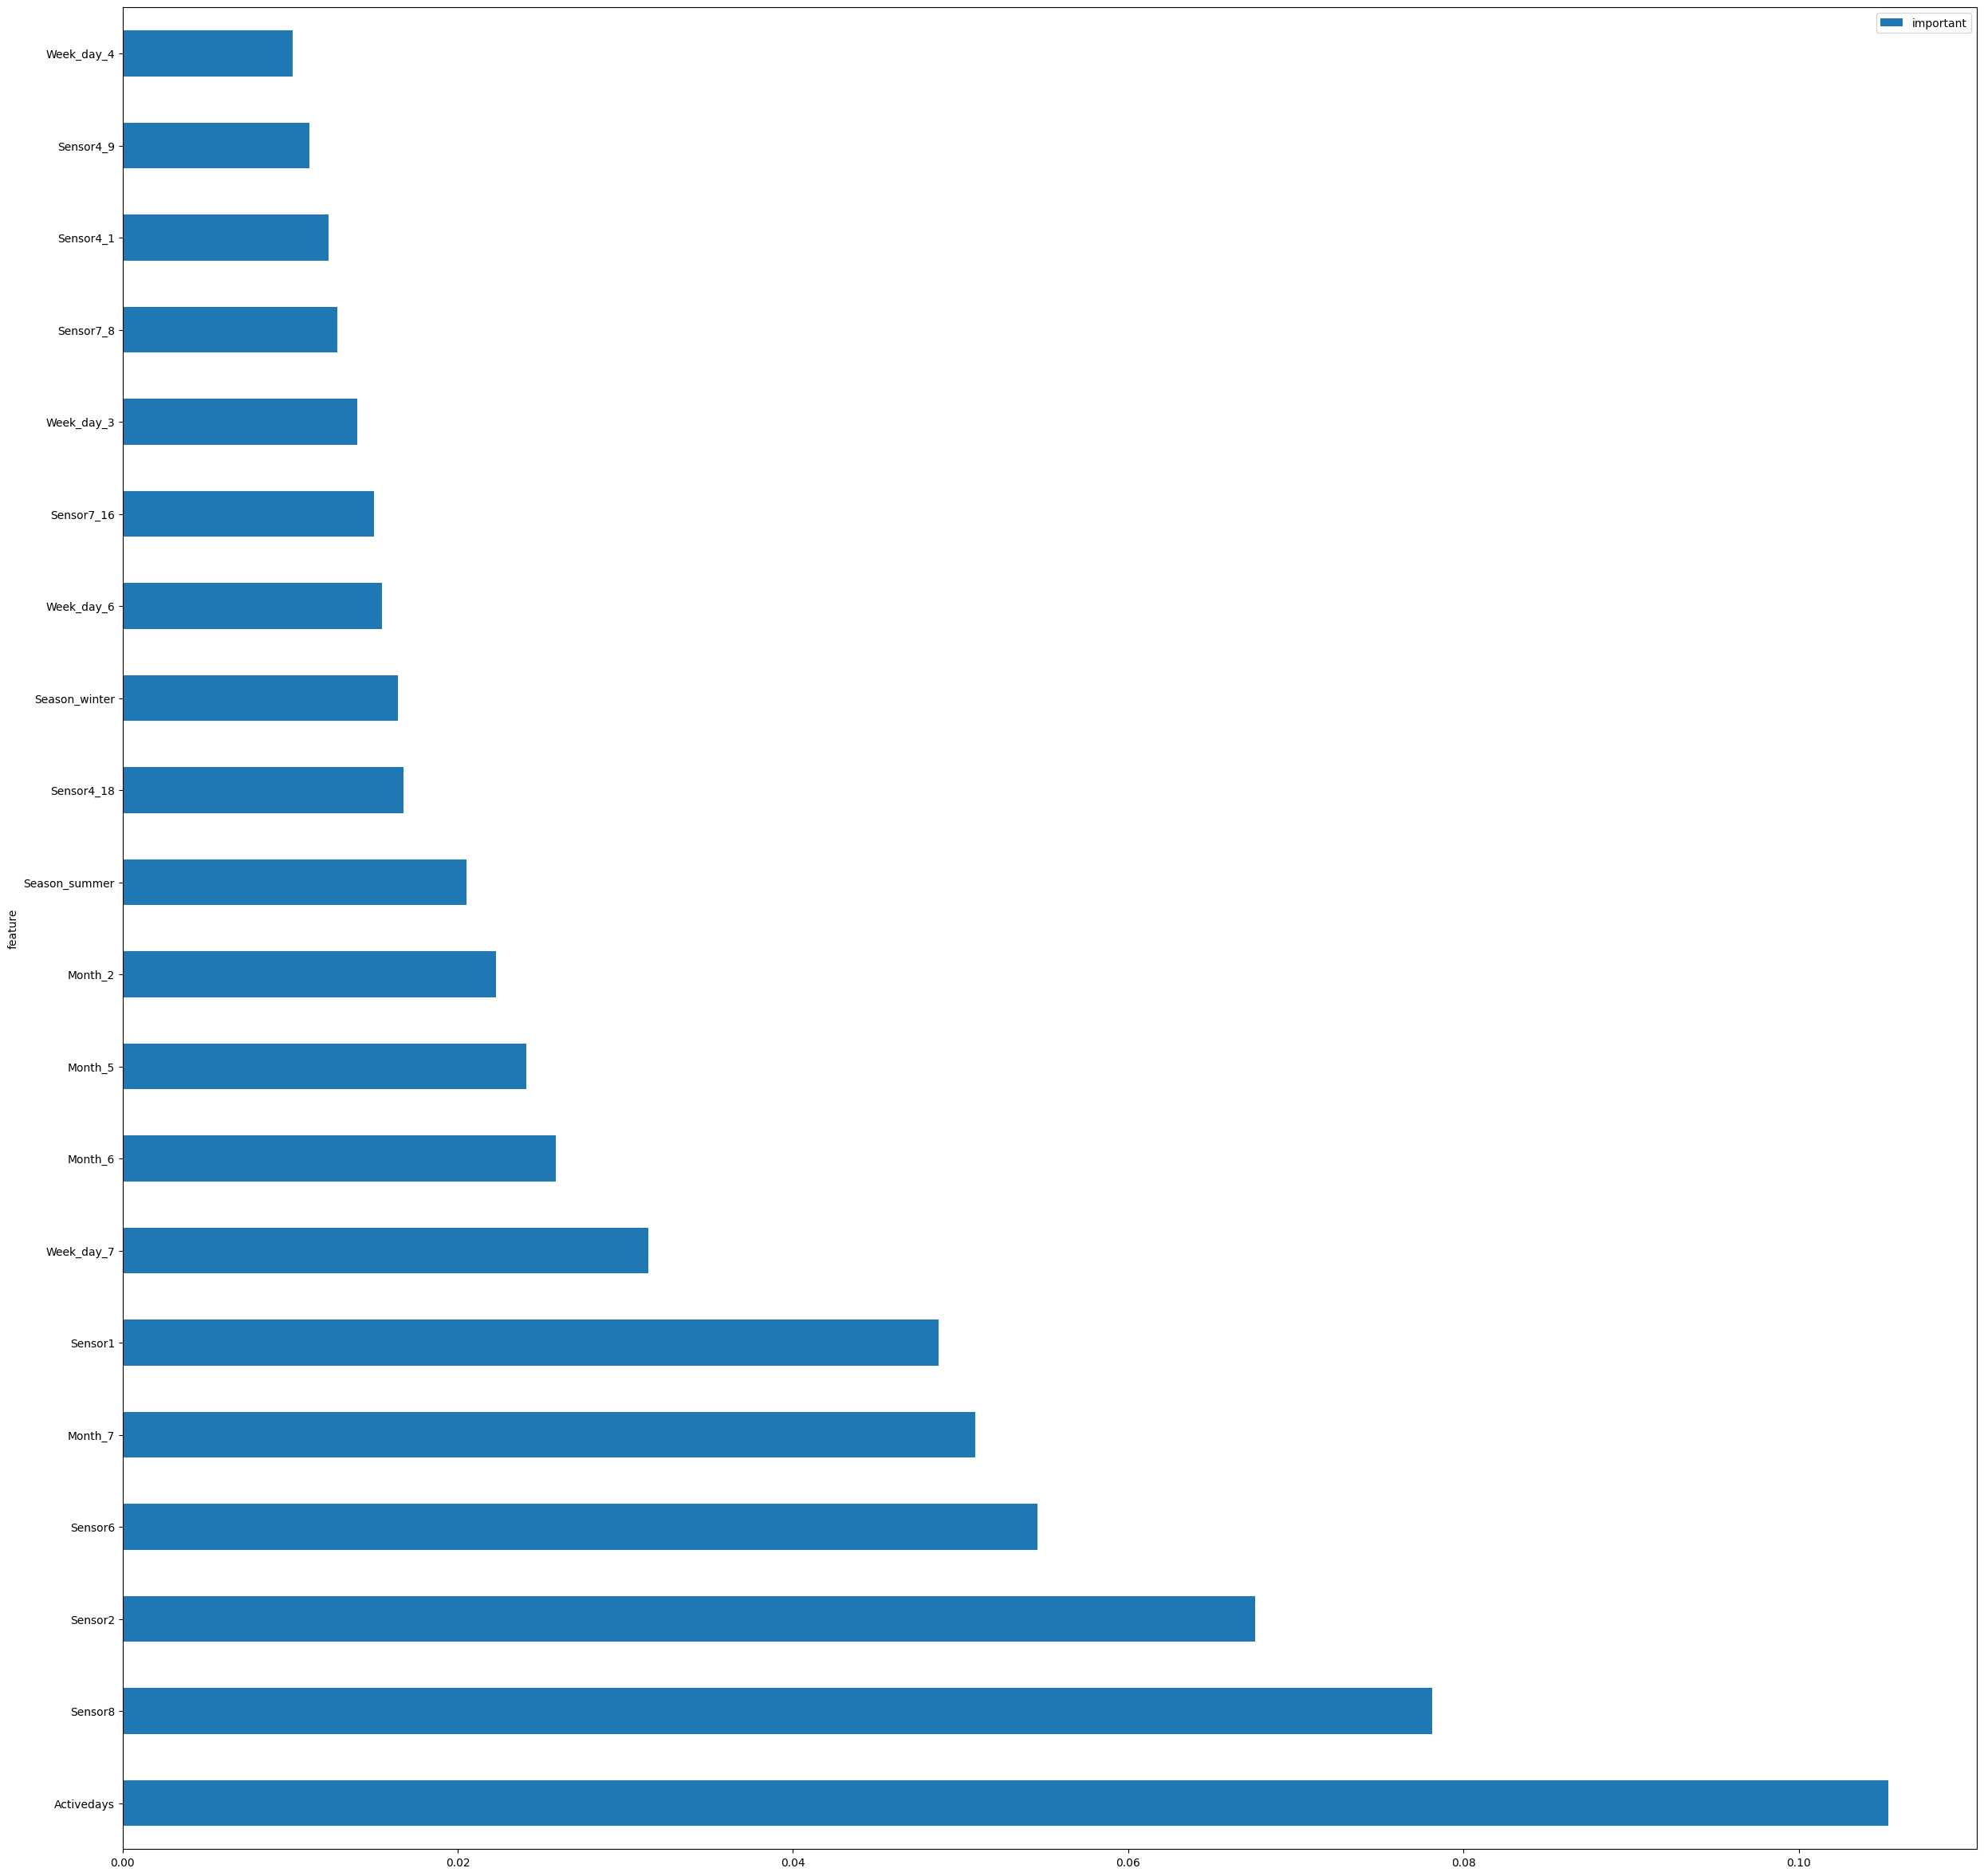

In [21]:
# Select features using RFC
clf = RandomForestClassifier(n_estimators=50, max_features='auto')
clf= clf.fit(X,Y)

features = pd.DataFrame()
features['feature'] = X.columns
features['important'] = clf.feature_importances_
features.sort_values(by=['important'], ascending=False,inplace=True)
features.set_index('feature', inplace=True)
features.iloc[:20,:].plot(kind='barh', figsize=(30,30))

In [22]:
# Selects important features 
model = SelectFromModel(clf,prefit=True)
x_reduced = model.transform(X)
x_reduced=pd.DataFrame(x_reduced)

In [23]:
# tested on RandomForestClassifier
X_train, X_test, y_train, y_test = train_test_split(x_reduced, Y, train_size=0.8, random_state=42)
ros = RandomOverSampler(random_state=42)
#With new training data, upsample the failed devices using the RandomOverSampler. This method object to over-sample the minority class(es) by picking samples at random with replacement.

X_res, y_res = ros.fit_resample(X_train, y_train)
X_res.shape

X_res = pd.DataFrame(X_res)
#After upsampling, build a random forest model to classify the failed devices.

rf = RandomForestClassifier(n_estimators=5000, random_state=21)
rf.fit(X_res,y_res)

rf_test_pred = rf.predict(X_test)
rf_test_cm = confusion_matrix(y_test, rf_test_pred)
rf_test_cm
accuracy_score(y_test, rf_test_pred)
print(classification_report_imbalanced(y_test,rf_test_pred))

# pre is precision, which is a measure of result relevancy;
# rec is recall, which is the same as sensitivity. Recall is a measure of how many truly relevant results are returned;
# spe is specificity;
# f1 is the harmonic average of the precision and recall;
# geo(Matthews correlation coefficient) is the geometric mean of specificity and sensitivity;
# iba is the index of imbalanced accuracy

                   pre       rec       spe        f1       geo       iba       sup

          0       0.97      0.99      0.62      0.98      0.79      0.64       218
          1       0.83      0.62      0.99      0.71      0.79      0.60        16

avg / total       0.96      0.97      0.65      0.96      0.79      0.64       234



# Model Training

In [24]:
log_reg = LogisticRegression()
knn = KNeighborsClassifier()
grad_boost = GradientBoostingClassifier()
random_forest_regr = RandomForestRegressor(n_estimators=100)
svm = SVC()
random_forest_cls = RandomForestClassifier(n_estimators=10)
xg_boost = XGBClassifier(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10)
clf = MLPClassifier(solver='lbfgs', alpha=1e-5,\
                    hidden_layer_sizes=(5, 2), random_state=1)
algorithms = [knn,log_reg,grad_boost,random_forest_regr,svm, random_forest_cls,xg_boost,clf]
names = ['KNeighborsClassifier','Logistic','GradientBoost','RandomForest','SVC','RandomForestCl','xgboost','neunet']

iba = make_index_balanced_accuracy(alpha=0.1, squared=True)(geo)

In [25]:
cross_val_fit_pred(X_train, y_train, algorithms=algorithms, names=names, ros=ros)

[16:28:32] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:34] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:37] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:39] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:42] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.


,Accuracy,geo_score,f1,recall,prec
KNeighborsClassifier,0.952889,0.866885,0.862925,0.873512,0.740169
xgboost,0.926123,0.863639,0.810287,0.869367,0.567488
GradientBoost,0.962527,0.855502,0.878063,0.868221,0.820923
Logistic,0.901472,0.821022,0.761947,0.829342,0.492101
RandomForestCl,0.953953,0.783941,0.843853,0.805284,0.842628
RandomForest,0.943258,0.778593,0.813737,0.804682,0.718202
SVC,0.638175,0.666966,0.514357,0.668643,0.169002
neunet,0.908999,0.165209,0.517327,0.521176,0.500000


## Model evaluation

In [26]:
probs1 = knn.predict_proba(X_test)
probs2 = xg_boost.predict_proba(X_test)
probs3 = grad_boost.predict_proba(X_test)
probs4 = random_forest_cls.predict_proba(X_test)
probs1 = probs1[:,1]
probs2 = probs2[:,1]
probs3 = probs3[:,1]
probs4 = probs4[:,1]

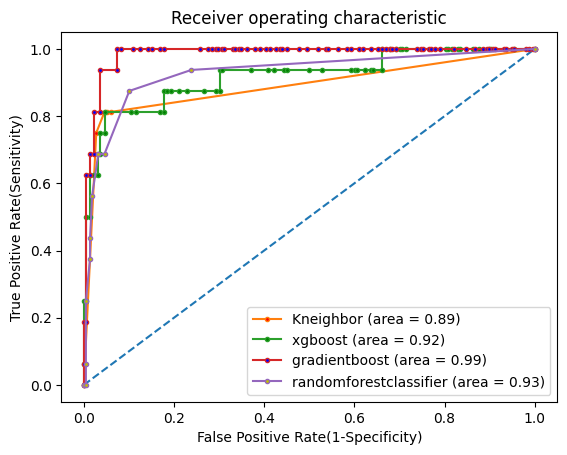

In [27]:
fpr1, tpr1, thresholds1 = roc_curve(y_test, probs1)
fpr2, tpr2, thresholds2 = roc_curve(y_test, probs2)
fpr3, tpr3, thresholds3 = roc_curve(y_test, probs3)
fpr4, tpr4, thresholds4 = roc_curve(y_test, probs4)
roc_auc1 = auc(fpr1, tpr1)
roc_auc2 = auc(fpr2, tpr2)
roc_auc3 = auc(fpr3, tpr3)
roc_auc4 = auc(fpr4, tpr4)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr1, tpr1, marker='.', markerfacecolor='r',label='Kneighbor (area = %0.2f)' % roc_auc1)
plt.plot(fpr2, tpr2, marker='.', markerfacecolor='g',label='xgboost (area = %0.2f)' % roc_auc2)
plt.plot(fpr3, tpr3, marker='.', markerfacecolor='b',label='gradientboost (area = %0.2f)' % roc_auc3)
plt.plot(fpr4, tpr4, marker='.',markerfacecolor='y',label='randomforestclassifier (area = %0.2f)' % roc_auc4)
plt.xlabel('False Positive Rate(1-Specificity)')
plt.ylabel('True Positive Rate(Sensitivity)')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [28]:
print("Geometric acc on test data with KNN", (geo(y_test, knn.predict(X_test))*100).round(2), "%")
print("Geometric acc on test data with Grad boost", (geo(y_test, grad_boost.predict(X_test))*100).round(2), "%")
print("Geometric acc on test data with SVM", (geo(y_test, svm.predict(X_test))*100).round(2), "%")
print("Geometric acc on test data with MLPClassifier", (geo(y_test, clf.predict(X_test))*100).round(2), "%")
print("Geometric acc on test data with XGBoost regressor", (geo(y_test, xg_boost.predict(X_test))*100).round(2), "%")
print("Geometric acc on test data with Random Forest classifier", (geo(y_test, random_forest_cls.predict(X_test))*100).round(2), "%")

Geometric acc on test data with KNN 88.05 %
Geometric acc on test data with Grad boost 85.6 %
Geometric acc on test data with SVM 71.36 %
Geometric acc on test data with MLPClassifier 0.0 %
Geometric acc on test data with XGBoost regressor 85.69 %
Geometric acc on test data with Random Forest classifier 65.69 %


In [29]:
X_train = X_train.to_numpy()
y_train = y_train.to_numpy()

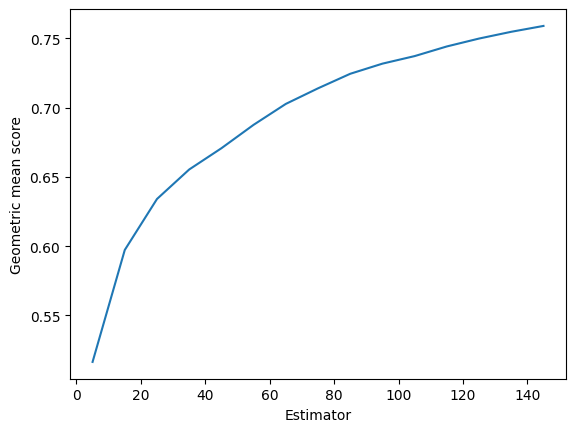

In [30]:
Geo1=[]
estimators = [i for i in range(5,150,10)]
Learning_rate = [i for i in np.arange(0.05,0.4,0.03)]
geo_score = []
kf = StratifiedKFold(n_splits=5,random_state=1,shuffle=True)
for i in estimators:
    for train_index,test_index in kf.split(X_train, y_train):
        xtr,xvd=X_train[train_index],X_train[test_index]
        ytr,yvd=y_train[train_index],y_train[test_index]
        xtr_res,ytr_res=ros.fit_resample(xtr, ytr)
        gbc =GradientBoostingClassifier(n_estimators=i).fit(xtr_res,ytr_res)
        y_pred_test = gbc.predict(xvd).round()
        geo_score.append(precision_score(yvd, y_pred_test))
    Geo1.append(np.mean(geo_score))
plt.plot(estimators,Geo1)
plt.xlabel('Estimator')
plt.ylabel('Geometric mean score')
plt.show()

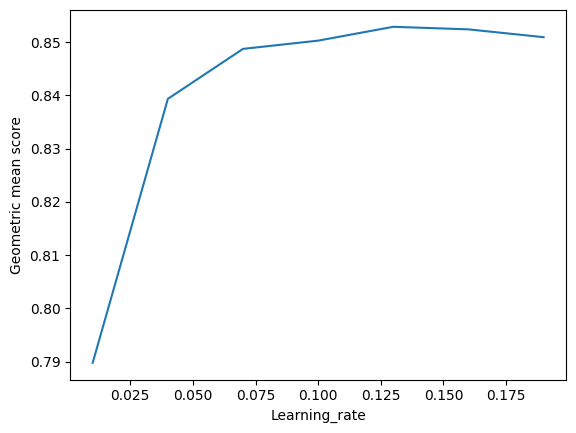

In [31]:
Geo2=[]
Learning_rate = [i for i in np.arange(0.01,0.2,0.03)]
geo_score = []
kf = StratifiedKFold(n_splits=5,random_state=1,shuffle=True)
for i in Learning_rate:
    for train_index,test_index in kf.split(X_train, y_train):
        xtr,xvd=X_train[train_index],X_train[test_index]
        ytr,yvd=y_train[train_index],y_train[test_index]
        xtr_res,ytr_res=ros.fit_resample(xtr, ytr)
        gbc =GradientBoostingClassifier(n_estimators=100,learning_rate=i).fit(xtr_res,ytr_res)
        y_pred_test = gbc.predict(xvd).round()
        geo_score.append(geo(yvd, y_pred_test))
    Geo2.append(np.mean(geo_score))
plt.xlabel("Learning_rate")
plt.ylabel("Geometric mean score")
plt.plot(Learning_rate,Geo2)
plt.show()